In [126]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Generate dataframe

In [127]:
inpath = 'data/codedqr-data-3245406.csv'
outpath = None

if (len(sys.argv) == 3):
    inpath = sys.argv[1]
    outpath = sys.argv[2]

print(f'making plots from {inpath}')

# load csv file into a pandas dataframe
df = pd.read_csv(inpath)

df['total'] = df.iloc[:, 3:].sum(axis=1) - df['recovery']

df = df[['n', 'p', 'f', 'recovery','final solve','post-ortho','cs construct','pbmgs','total']]


making plots from data/codedqr-data-3245406.csv


## Total job runtime

In [128]:

seconds = int(df['total'].sum())
mins = seconds // 60
hours = mins // 60
days = hours // 24
seconds %= 60
mins %= 60
hours %= 24

print(f'total execution time: {days}-{hours}:{mins}:{seconds}')


total execution time: 3-18:40:14


## Calculate Proportional Overhead and Sums

In [129]:

# Calculate Tqr for f=0
df['tqr'] = df['pbmgs']

f_zero_dict = df.loc[df['f'] == 0].set_index(['n', 'p'])['tqr'].to_dict()

df.loc[df['f'] != 0, 'tqr'] = df.loc[df['f'] != 0].apply(
    lambda row: f_zero_dict.get((row['n'], row['p']), row['tqr']),
    axis=1
)

# Calculate Tcomp
df['tcomp'] = df['pbmgs'] - df['tqr']

# Take proportions
df['encode'] = df['cs construct'] / df['tqr']
df['post'] = df['post-ortho'] / df['tqr']
df['decode'] = df['recovery'] / df['tqr'] / ( df['p'] + df['f'] )
df['comp'] = df['tcomp'] / df['tqr']

df['overhead'] = df['comp'] + df['encode'] + df['post']

print(df.iloc[:,-5:])

          encode          post        decode      comp      overhead
0   1.520378e-09  3.749778e-07  5.834580e-08  0.000000  3.764982e-07
1   3.515382e-04  1.152206e-03  3.569816e-04  0.274172  2.756754e-01
2   6.211683e-04  7.789409e-04  6.631466e-04  0.550176  5.515761e-01
3   1.013349e-03  6.197931e-04  1.214319e-03  0.816337  8.179697e-01
4   2.345502e-09  3.407182e-07  4.298869e-08  0.000000  3.430637e-07
..           ...           ...           ...       ...           ...
68  3.184822e-10  5.289009e-08  7.291305e-09  0.000000  5.320858e-08
69  2.302757e-04  1.019201e-03  2.565344e-04  0.181502  1.827511e-01
70  3.953935e-11  4.294315e-09  8.218372e-10  0.000000  4.333854e-09
71  6.569912e-05  2.341248e-04  7.250731e-05  0.187227  1.875271e-01
72  1.194083e-04  1.643156e-04  1.311407e-04  0.401081  4.013648e-01

[73 rows x 5 columns]


## Take averages for all iterations

In [130]:
config_cols = ['n', 'f', 'p']

df_means = df.groupby(config_cols)[df.columns[3:]].mean()
df_std = df.groupby(config_cols)[df.columns[3:]].std()

print(df_means[:5])


            recovery  final solve  post-ortho  cs construct       pbmgs  \
n     f p                                                                 
12000 0 6   0.000117          0.0    0.000130  5.862158e-07  379.799915   
        8   0.000091          0.0    0.000098  5.816401e-07  263.453315   
        10  0.000104          0.0    0.000099  5.665049e-07  182.020790   
        12  0.000115          0.0    0.000119  5.874705e-07  145.082780   
      1 6   0.948043          0.0    0.436176  1.336460e-01  482.685650   

                 total         tqr      tcomp        encode          post  \
n     f p                                                                   
12000 0 6   379.800046  379.799915    0.00000  1.543510e-09  3.424457e-07   
        8   263.453414  263.453315    0.00000  2.208012e-09  3.727559e-07   
        10  182.020890  182.020790    0.00000  3.112305e-09  5.451056e-07   
        12  145.082899  145.082780    0.00000  4.049214e-09  8.191108e-07   
      1 6   

# Absolute time and overhead over $p$

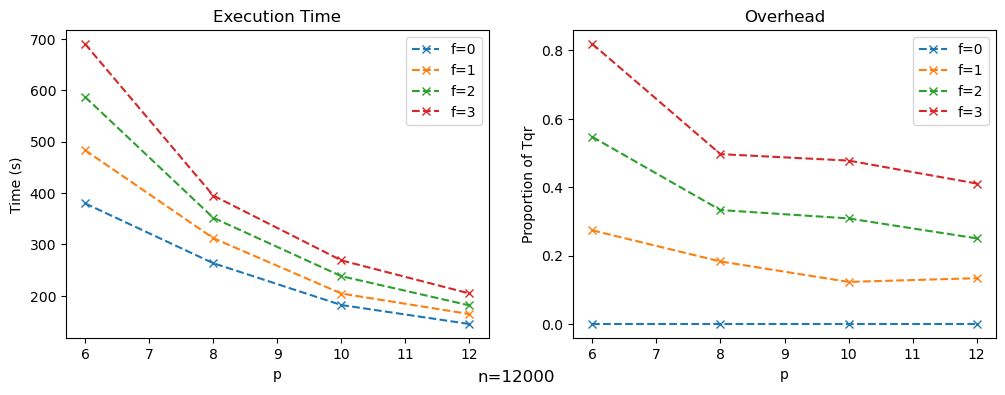

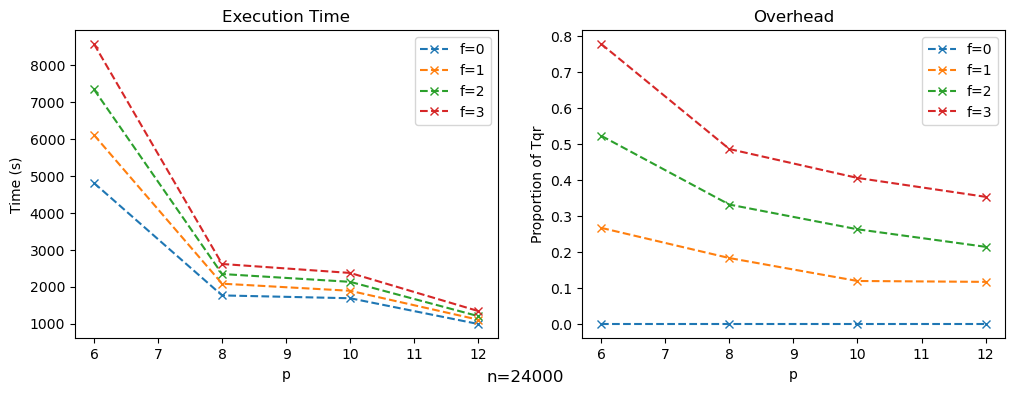

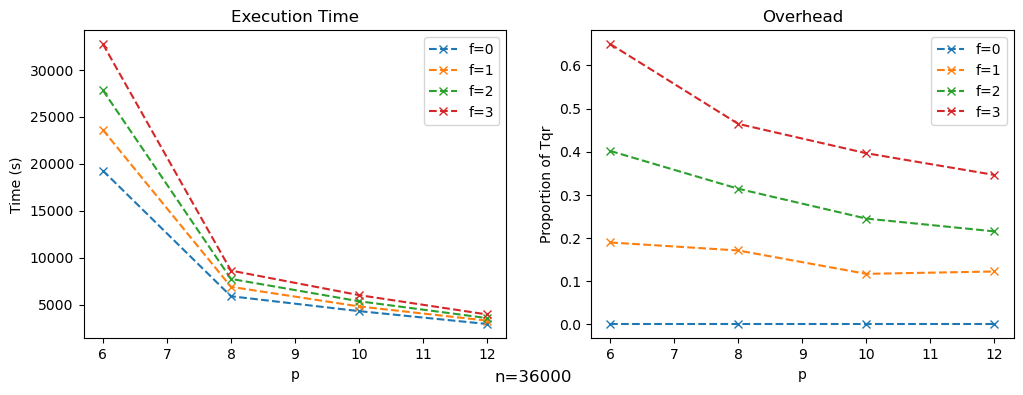

In [131]:
for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)
    
    fig, (time, overhead) = plt.subplots(1, 2, figsize=(12, 4))
    fig.text(0.5,0, f'n={n_val}', size=12, ha="center")
    
    for f_val in df['f'].unique():
        
        f_rows = n_rows.query(f"f == {f_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        p_vals = f_rows.index.get_level_values('p')
        
        time.plot(p_vals, f_rows['total'], label=f'f={f_val}', linestyle='--', marker='x')
        overhead.plot(p_vals, f_rows['overhead'], label=f'f={f_val}', linestyle='--', marker='x')

    
    time.set_title(f'Execution Time') 
    time.set_xlabel('p')
    time.set_ylabel('Time (s)')
    time.legend()
    
    overhead.set_title(f'Overhead') 
    overhead.set_xlabel('p')
    overhead.set_ylabel('Proportion of Tqr')
    overhead.legend()
    
    fig.show()
       

# Coding Breakdown over $p$

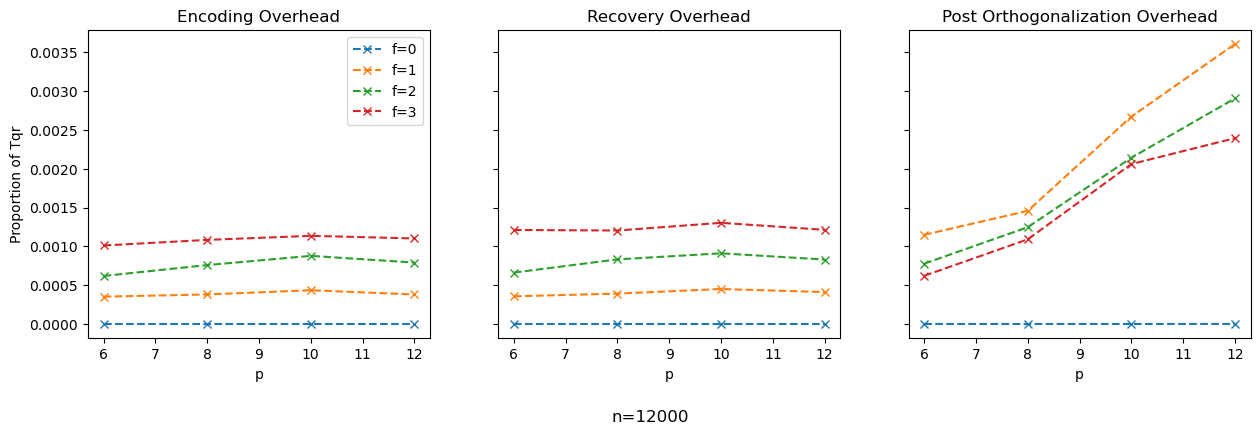

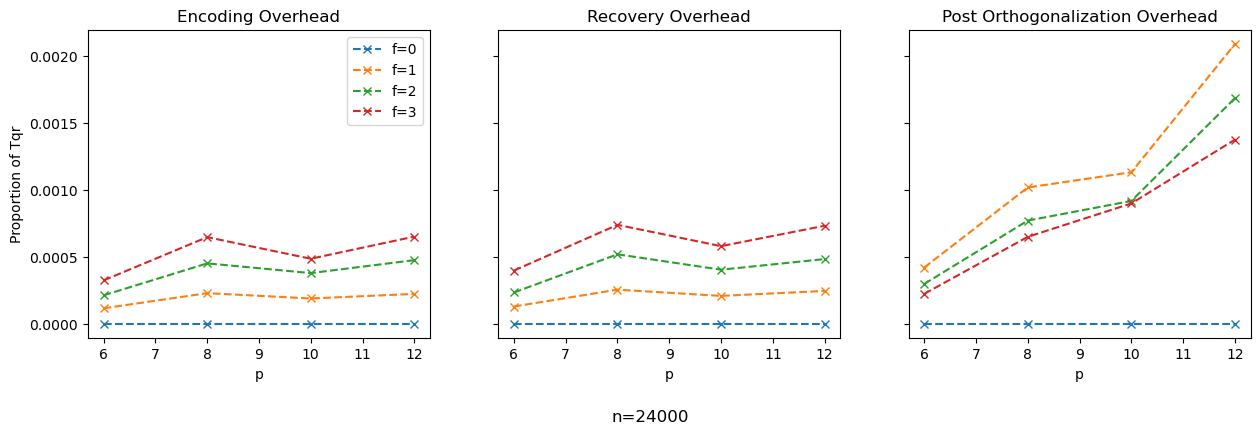

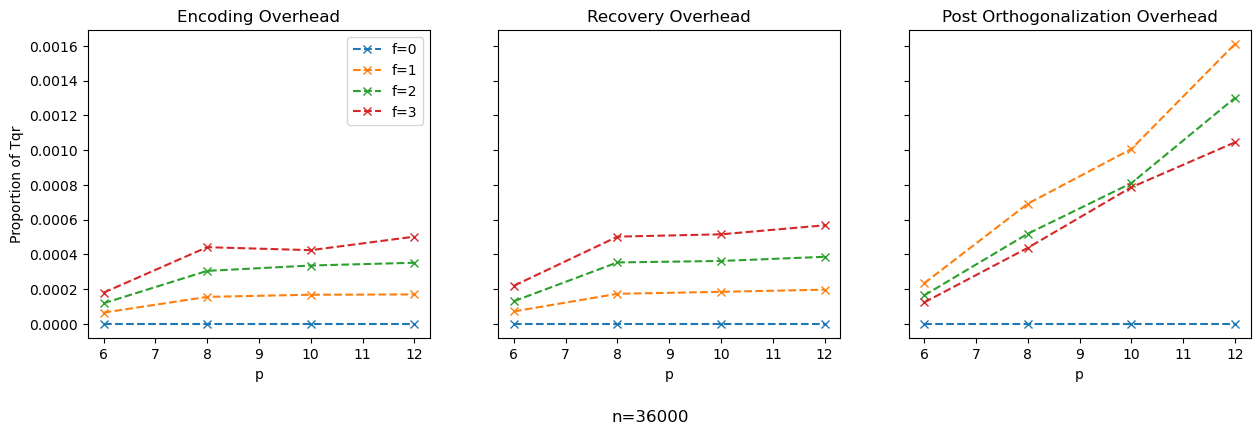

In [132]:
for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)
    
    fig, (enc, recov, post) = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
    fig.text(0.5,-0.1, f'n={n_val}', size=12, ha="center")  
  
    for f_val in df['f'].unique():
        
        f_rows = n_rows.query(f"f == {f_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        p_vals = f_rows.index.get_level_values('p')
        
        enc.plot(p_vals, f_rows['encode'], label=f'f={f_val}', linestyle='--', marker='x')
        recov.plot(p_vals, f_rows['decode'], label=f'f={f_val}', linestyle='--', marker='x')
        post.plot(p_vals, f_rows['post'], label=f'f={f_val}', linestyle='--', marker='x')

    
    enc.set_title(f'Encoding Overhead') 
    enc.set_xlabel('p')
    enc.set_ylabel('Proportion of Tqr')
    enc.legend()
    
    recov.set_title(f'Recovery Overhead')
    recov.set_xlabel('p')
    
    post.set_title(f'Post Orthogonalization Overhead')
    post.set_xlabel('p')
    
    fig.show()


# Overhead over $f$

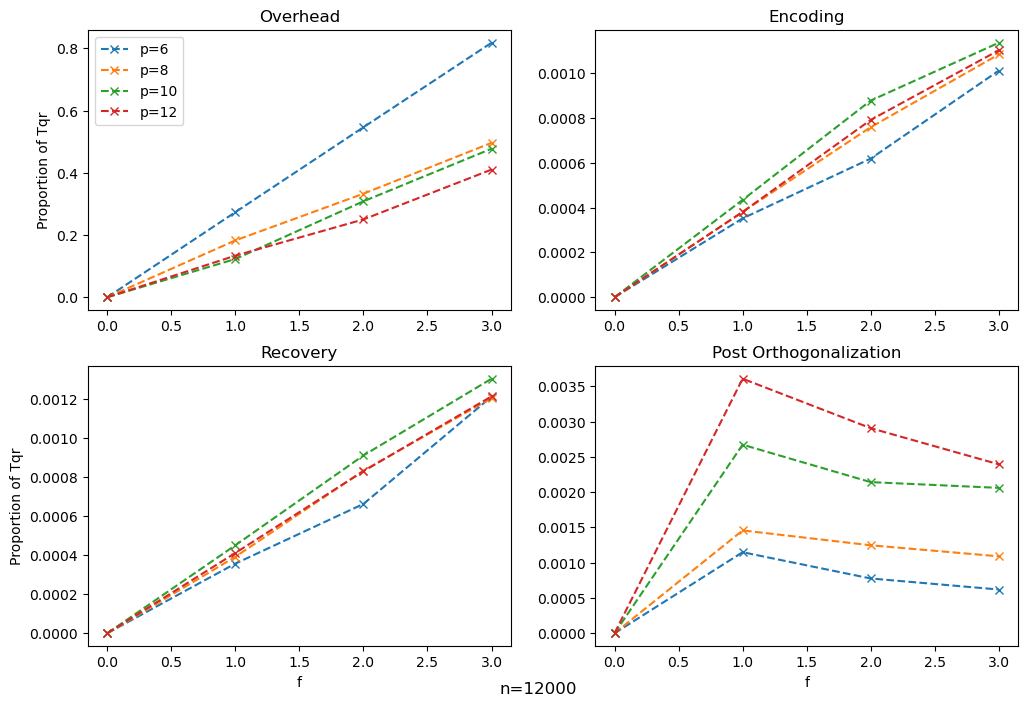

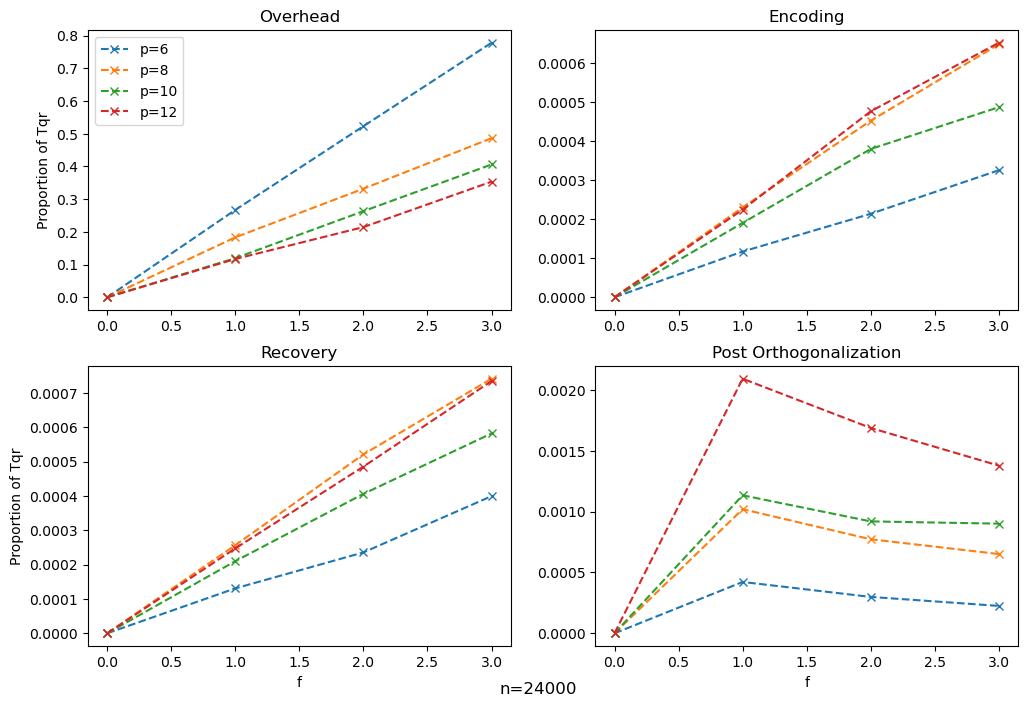

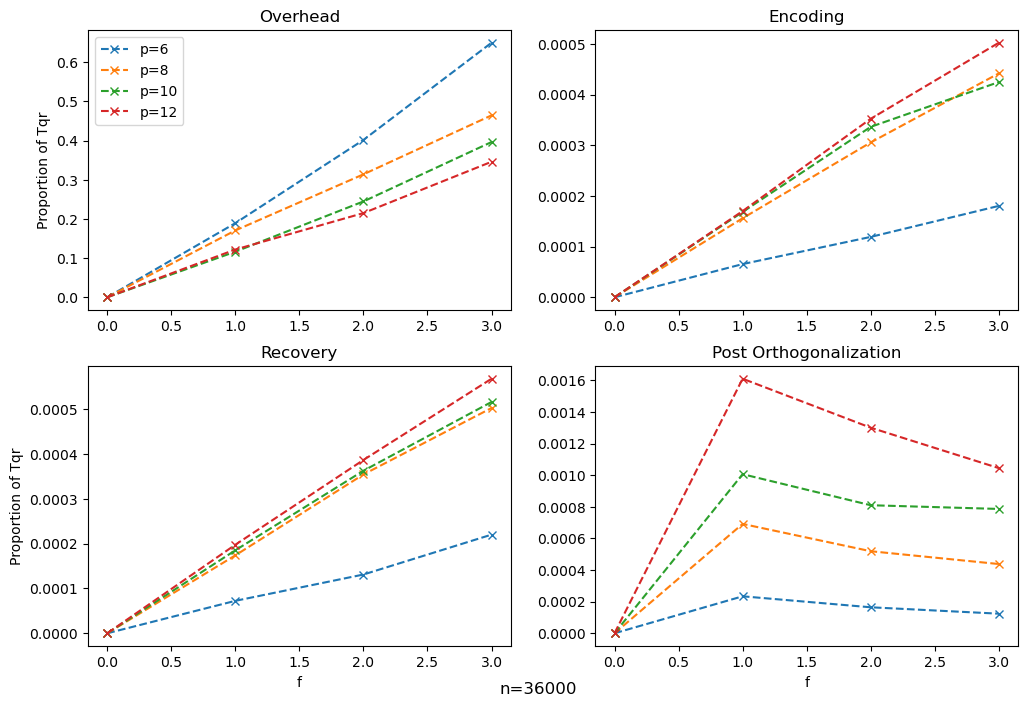

In [133]:
for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)
    
    fig, ((overhead, enc), (recov, post)) = plt.subplots(2, 2, figsize=(12, 8))
    fig.text(0.5,0.05, f'n={n_val}', size=12, ha="center")
    
    for p_val in df['p'].unique():
        
        p_rows = n_rows.query(f"p == {p_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        f_vals = p_rows.index.get_level_values('f')
        
        overhead.plot(f_vals, p_rows['overhead'], label=f'p={p_val}', linestyle='--', marker='x')
        enc.plot(f_vals, p_rows['encode'], label=f'p={p_val}', linestyle='--', marker='x')
        recov.plot(f_vals, p_rows['decode'], label=f'p={p_val}', linestyle='--', marker='x')
        post.plot(f_vals, p_rows['post'], label=f'p={p_val}', linestyle='--', marker='x')

    overhead.set_title(f'Overhead')
    overhead.set_ylabel('Proportion of Tqr')
    overhead.legend()
    
    enc.set_title(f'Encoding') 
    
    recov.set_title(f'Recovery')
    recov.set_xlabel('f')
    recov.set_ylabel('Proportion of Tqr')

    post.set_title(f'Post Orthogonalization')
    post.set_xlabel('f')
    
    fig.show()